### Prototype $\nu_\tau$ Normalization Fit for the CNN Double Pulse Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from stat_analysis import *
import plotting
import math

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [4]:
mc_df = pd.read_hdf('nominal_new_sim_09_29_2021.h5', 'df')

### Build signal and background templates

In [5]:
ASTRO_PHI = 2.12
ASTRO_GAMMA = 2.87

n_bins_net1 = 4
n_bins_net3 = 4

sig_NET1 = 0.99
sig_NET2 = 0.98
sig_NET3 = 0.85

livetime = 305684668.46

net3_val = 0.95
qasym_val = 0.05
outer_nums = np.array([75, 76, 77, 78, 72, 73, 74, 67, 59, 50, 40, 30, 21, 
                       13, 6, 5, 4, 3, 2, 1, 7, 14, 22, 31, 41, 51, 60, 68])
inner_or_qasym = lambda x: (~x.stnum0.isin(outer_nums)) | ((x.n3 > net3_val) & (x.q_asym > qasym_val))

### Priors for systematic effects

In [6]:
# flux priors
astro_norm_mean = 1.0
astro_norm_width = 0.3
conv_norm_mean = 1.0
conv_norm_width = 0.3
prompt_norm_mean = 1.0
prompt_norm_width = 0.3
mg_norm_mean = 2.0
mg_norm_width = 1.0

# detector effects are: DOM eff, scat/abs
syst_slopes = (0.6, 1) 
syst_widths = (0.1, 0.05) 
prior_types = ('uniform', 'norm')

### Apply signal cuts to the MC dataframe

In [7]:
exp_df = pd.DataFrame(mc_df[(mc_df.n1 > sig_NET1) & (mc_df.n2 > sig_NET2) & (mc_df.n3 > sig_NET3)])
exp_df = exp_df[inner_or_qasym].copy()

In [8]:
net1_bins = np.linspace(sig_NET1, 1.0, n_bins_net1 + 1)
net3_bins = np.linspace(sig_NET3, 1.0, n_bins_net3 + 1)

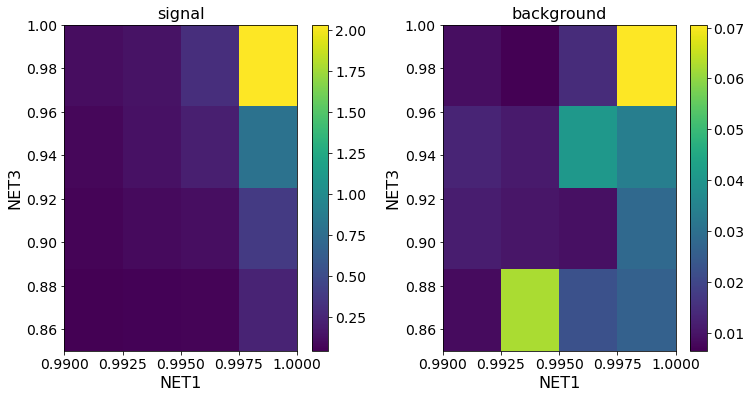

In [9]:
ana = Analysis(exp_df, livetime, net1_bins, net3_bins,
               astro_phi=ASTRO_PHI, astro_gamma=ASTRO_GAMMA,
               conv_model='honda2006',
               prompt_model='H3a_SIBYLL23C_pr',
               syst_slopes=syst_slopes,
               syst_widths=syst_widths,
               prior_types=prior_types,
               astro_norm_mean=astro_norm_mean,
               astro_norm_width=astro_norm_width,
               conv_norm_mean=conv_norm_mean,
               conv_norm_width=conv_norm_width,
               prompt_norm_mean=prompt_norm_mean,
               prompt_norm_width=prompt_norm_width,
               mg_norm_mean=mg_norm_mean,
               mg_norm_width=mg_norm_width)
ana.plot_templates()
plt.gcf().savefig('HESE_templates.png', bbox_inches='tight')

In [10]:
ana.sig_hist.sum()

4.83704663971826

In [11]:
ana.bg_hist.sum()

0.37656545104326755

### Plot an example histogram 

In [12]:
# sample_hist = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 2, 3]])

# Asimov hist
sample_hist = ana.sig_hist + ana.bg_hist

Text(0.5, 1.0, 'Asimov hist')

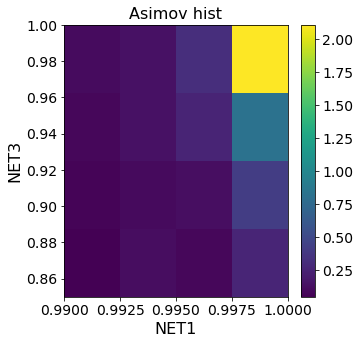

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
plotting.plot_hist(net1_bins, net3_bins, sample_hist, ax)
ax.set_title('Asimov hist')

### Conduct an LLH scan and an LLH fit for the pseudo experiment

In [14]:
llh_min, best_llh = ana.fit_lambda_tau(sample_hist)
lambda_taus = np.linspace(0, 2, 1000)
llh_scan = ana.llh_scan(sample_hist, lambda_taus)

0.9896768960521017

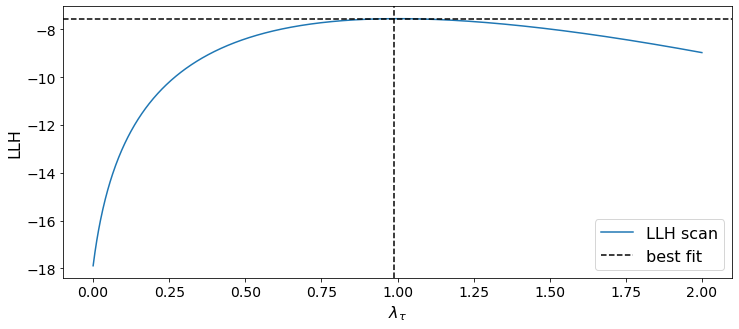

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(lambda_taus, llh_scan, label='LLH scan')
ax.axhline(best_llh, color='black', linestyle='--', label='best fit')
ax.axvline(llh_min, color='black', linestyle='--')
ax.set_xlabel(r'$\lambda_\tau$')
ax.set_ylabel('LLH')
ax.legend()
llh_min

### Sample the TS for the null hypothesis

In [16]:
%%time
null_ts, _ = ana.sample_TS(0, 3_000_000)

CPU times: user 43.4 s, sys: 328 ms, total: 43.7 s
Wall time: 43.8 s


In [17]:
nominal_hists = ana.sample(1, n_hists=10000)
nominal_null_ts, _ = ana.calculate_TS(0, nominal_hists)

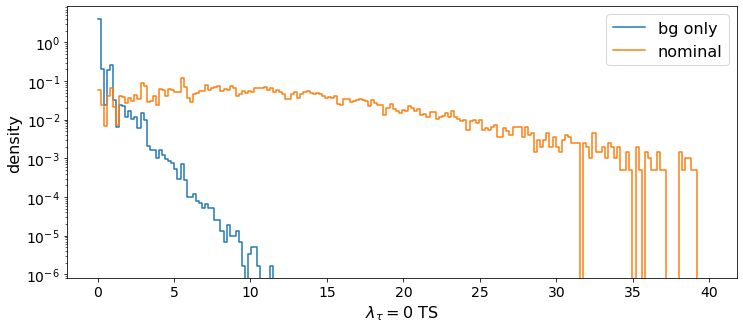

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))

ts_bins = np.linspace(0, 40, 200)
ts_hist, _ = np.histogram(null_ts, bins=ts_bins, density=True)
nom_hist, _ =  np.histogram(nominal_null_ts, bins=ts_bins, density=True)

ax.step(ts_bins[:-1], ts_hist, where='post', label='bg only')
ax.step(ts_bins[:-1], nom_hist, where='post', label='nominal')
ax.set_xlabel(r'$\lambda_\tau = 0$ TS')
ax.set_ylabel('density')
ax.set_yscale('log')
ax.legend()

### Build the TS plane

In [19]:
max_lambda = 4
n_steps = 401
trials_per_lambda = 10000
cl = 0.9
cl_onesig = 0.6827
confidence_levels = [cl_onesig, cl, 0.95]

In [20]:
%%time
ts_plane = ana.build_TS_plane(max_lambda, n_steps, 
                              trials_per_lambda, confidence_levels)

CPU times: user 49.5 s, sys: 15.6 ms, total: 49.6 s
Wall time: 49.7 s


(0.0, 4.0)

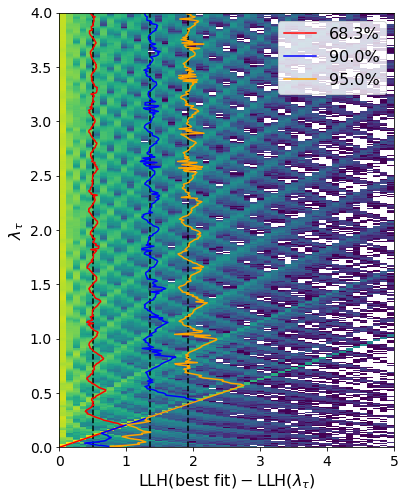

In [21]:
fig, ax = plt.subplots(figsize=(6, 8))
plotting.plot_ts_plane(ax, ts_plane, hist_bins=np.linspace(0, 5, 50))

# include two example scans
lambda_taus = np.linspace(0, max_lambda, 1000)
ts_scan, best_fit, best_llh = ana.scan_TS(sample_hist, lambda_taus)
# ax.plot(ts_scan, lambda_taus, 'k-')
example_bg = np.zeros_like(ana.sig_hist)
ts_scan, best_fit, best_llh = ana.scan_TS(example_bg, lambda_taus)
# ax.plot(ts_scan, lambda_taus, 'k--')
ax.set_xlim(0, 5)
ax.set_ylim(0, 4)

### Plot the group means and vars

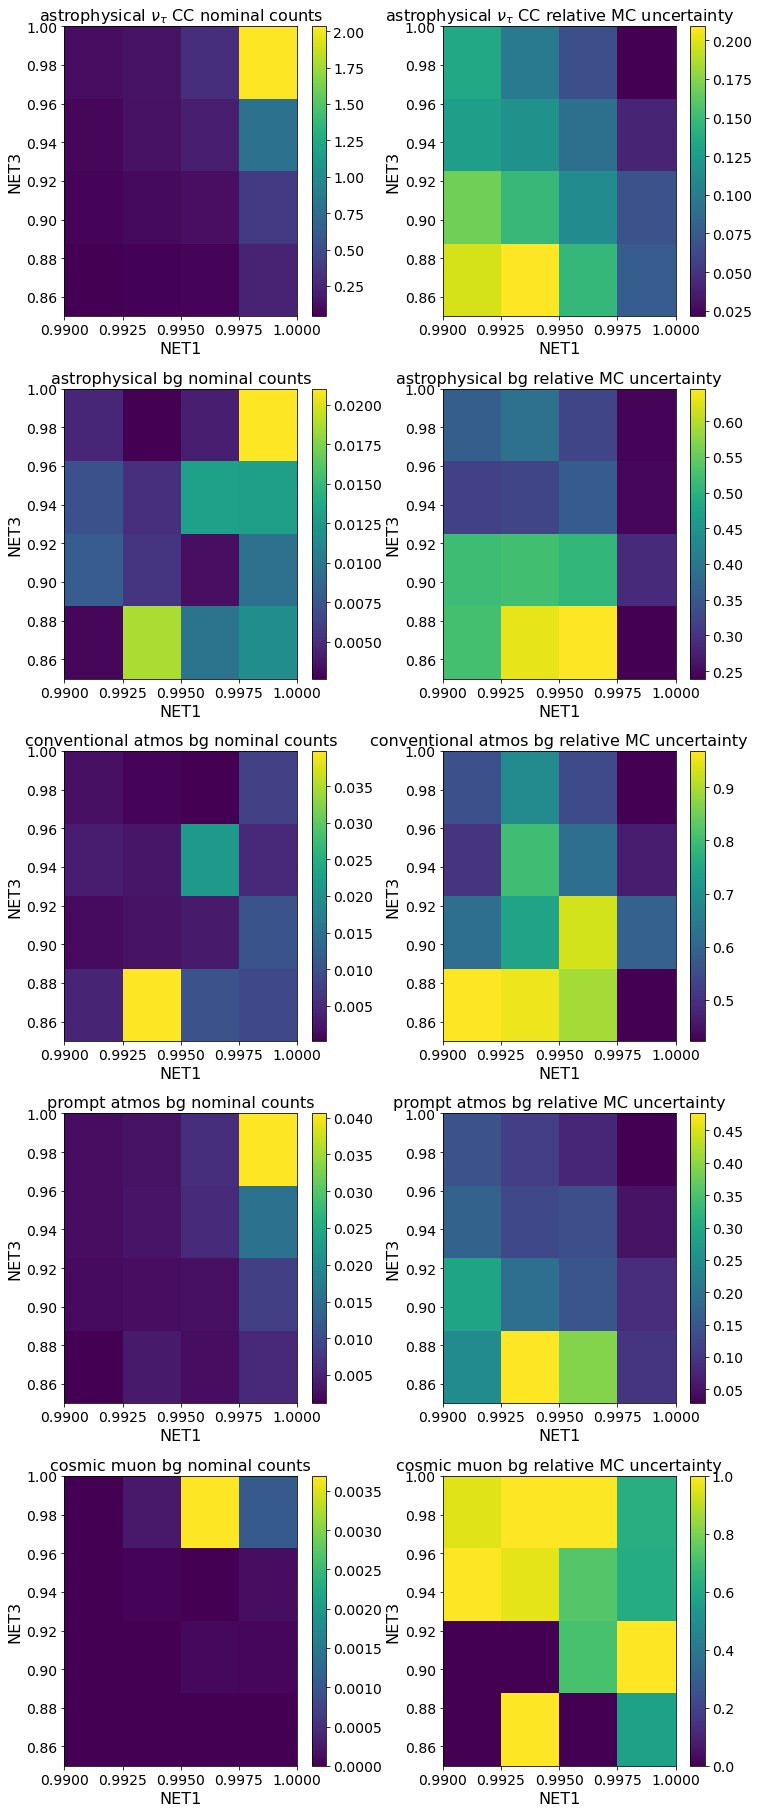

In [22]:
fig, axes = plt.subplots(figsize=(12, 32), nrows=5, ncols=2)
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.3)
ana.plot_groups(axes)

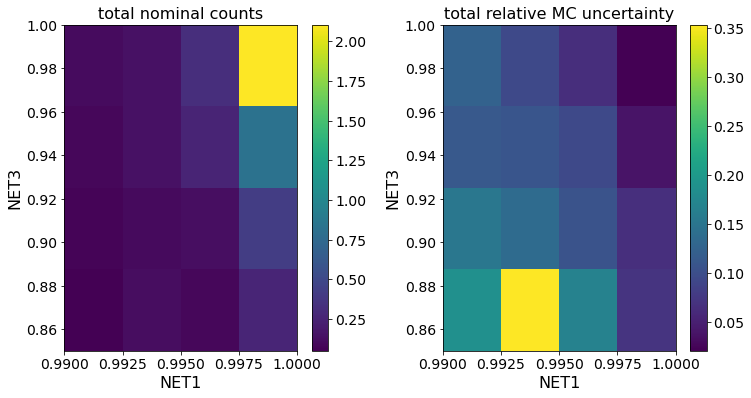

In [23]:
comb_mean = sum(ana.group_hists)
comb_var = sum(ana.group_vars)
rel_unc = np.sqrt(comb_var) / comb_mean
plotting.plot_hists(net1_bins, net3_bins, 
                    comb_mean, rel_unc, 
                    ("total nominal counts", "total relative MC uncertainty"))

In [24]:
%%time
null_ts_with_syst, _ = ana.sample_TS(0, 3_000_000, with_syst=True)

CPU times: user 46.9 s, sys: 3.36 s, total: 50.3 s
Wall time: 50.3 s


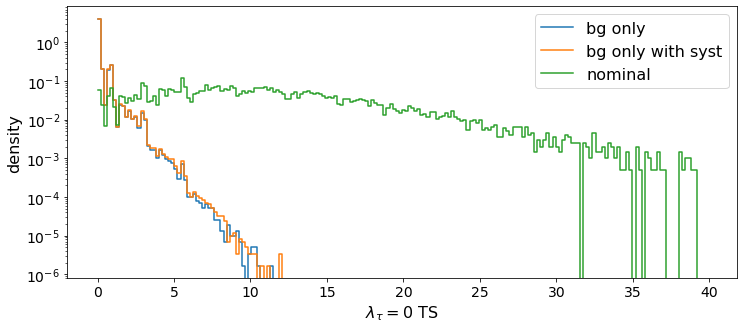

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))

syst_hist, _ = np.histogram(null_ts_with_syst, bins=ts_bins, density=True)

ax.step(ts_bins[:-1], ts_hist, where='post', label='bg only')
ax.step(ts_bins[:-1], syst_hist, where='post', label='bg only with syst')
ax.step(ts_bins[:-1], nom_hist, where='post', label='nominal')
ax.set_xlabel(r'$\lambda_\tau = 0$ TS')
ax.set_ylabel('density')
ax.set_yscale('log')

ax.legend(fontsize=16)

In [26]:
%%time
ts_plane_syst = ana.build_TS_plane(max_lambda, n_steps, 
                                  trials_per_lambda, confidence_levels,
                                  with_syst=True)

CPU times: user 48 s, sys: 0 ns, total: 48 s
Wall time: 48 s


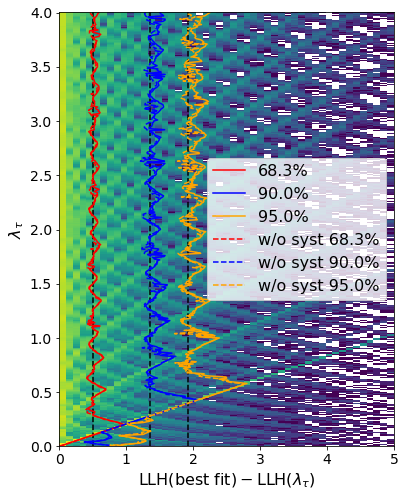

In [50]:
fig, ax = plt.subplots(figsize=(6, 8))
plotting.plot_ts_plane(ax, ts_plane_syst, hist_bins=np.linspace(0, 5, 50),
                       other_cvs=ts_plane["critical_values"], other_prefix='w/o syst')
plt.gcf().savefig('cvs_with_syst.png', bbox_inches='tight')

### Distribution of best fit values assuming the nominal tau flux

In [28]:
n_hists = 10000
nom_hists = ana.sample(lambda_tau=1, n_hists=n_hists)
ts, best_fits = ana.calculate_TS(0, nom_hists)

0.9928173965924987

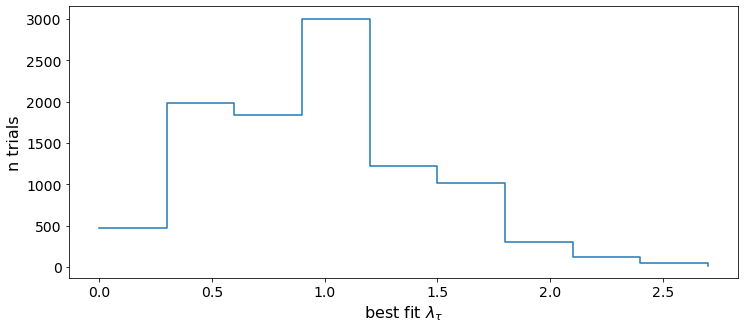

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
best_fit_bins = np.linspace(0, 3, 11)
hist = np.histogram(best_fits, bins=best_fit_bins)[0]
ax.step(best_fit_bins[:-1], hist, where='post')
ax.set_xlabel(r'best fit $\lambda_\tau$')
ax.set_ylabel('n trials')
best_fits.mean()

In [30]:
syst_hists = ana.sample(lambda_tau=1, n_hists=n_hists, with_syst=True)
ts, best_fits_syst = ana.calculate_TS(0, syst_hists)

1.0025391129289887

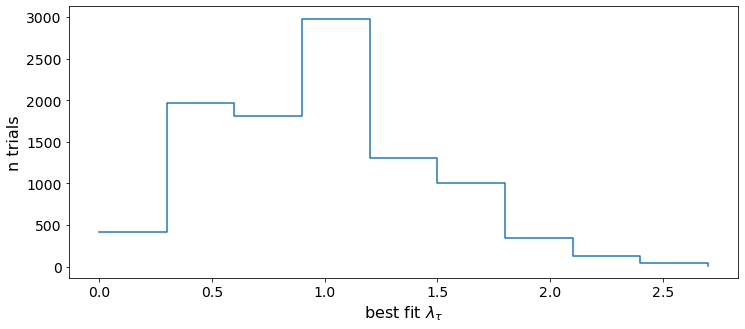

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
hist = np.histogram(best_fits_syst, bins=best_fit_bins)[0]
ax.step(best_fit_bins[:-1], hist, where='post')
ax.set_xlabel(r'best fit $\lambda_\tau$')
ax.set_ylabel('n trials')
best_fits_syst.mean()

### Visualize 90% confidence intervals

In [32]:
best_fits = []
lower_lims = []
upper_lims = []
lower_lims_syst = []
upper_lims_syst = []
scans = []
for hist in syst_hists:
    ts, best_fit, _ = ana.scan_TS(hist, ts_plane['lambdas'])
    best_fits.append(best_fit)
    accepted = np.argwhere(ts <= ts_plane['critical_values'][:, 1])
    lower_lims.append(ts_plane['lambdas'][accepted[0][0]])
    upper_lims.append(ts_plane['lambdas'][accepted[-1][0]])
    accepted_syst = np.argwhere(ts <= ts_plane_syst['critical_values'][:, 1])
    lower_lims_syst.append(ts_plane['lambdas'][accepted_syst[0][0]])
    upper_lims_syst.append(ts_plane['lambdas'][accepted_syst[-1][0]])
    scans.append(ts)
    
best_fits = np.array(best_fits)
lower_lims = np.array(lower_lims)
upper_lims = np.array(upper_lims)
scans = np.array(scans)

### Check coverage

In [33]:
np.count_nonzero((lower_lims <= 1) & (1 <= upper_lims)) / len(nom_hists)

0.9037

In [34]:
def plot_pseudo_expt(scan, lambdas, lower_lim, upper_lim, cvs, lower_lim_syst, upper_lim_syst, cvs_syst, hist, show_syst=True):
    fig, axes = plt.subplots(figsize=(15, 5), ncols=2, gridspec_kw=dict(width_ratios=(0.66, 0.33)))
    
    axiter = axes.flat
    ax = next(axiter)
    ax.plot(lambdas, scan, label='observed')
#     ax.plot(lambdas, cvs[0], label='68% critical values')
    ax.plot(lambdas, cvs[1], label='90% critical values')

#     ax.plot(lambdas, cvs_syst[0], label='68% critical values w/ systematics')
    if show_syst:
        ax.plot(lambdas, cvs_syst[1], label='90% critical values w/ systematics')

    
    ax.axvline(lower_lim, linestyle='--', color='black')
    ax.axvline(upper_lim, linestyle='--', color='black')
    
    if show_syst:
        ax.axvline(lower_lim_syst, linestyle='-', color='black')
        ax.axvline(upper_lim_syst, linestyle='-', color='black')

    ax.set_ylim(0, 3)
    ax.set_xlabel(r'$\lambda_\tau$')
    ax.set_ylabel(r'$\mathrm{LLH}(\mathrm{best~fit}) - \mathrm{LLH}(\lambda_\tau)$')
    ax.legend()

    n_obs = hist.sum()
    if math.floor(n_obs) != n_obs:
        n_obs = f'{n_obs:.2f}' 
    
    if show_syst:
        interval = f'[{lower_lim_syst:.2f}, {upper_lim_syst:.2f}]'
    else:
        interval = f'[{lower_lim:.2f}, {upper_lim:.2f}]'
        
    ax.set_title(f'{n_obs} observed events, interval = {interval}')
        
    ax = next(axiter)
    plotting.plot_hist(net1_bins, net3_bins, hist, ax)

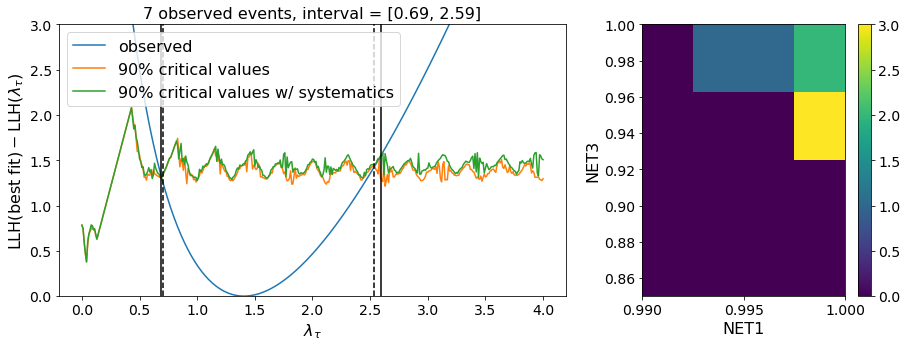

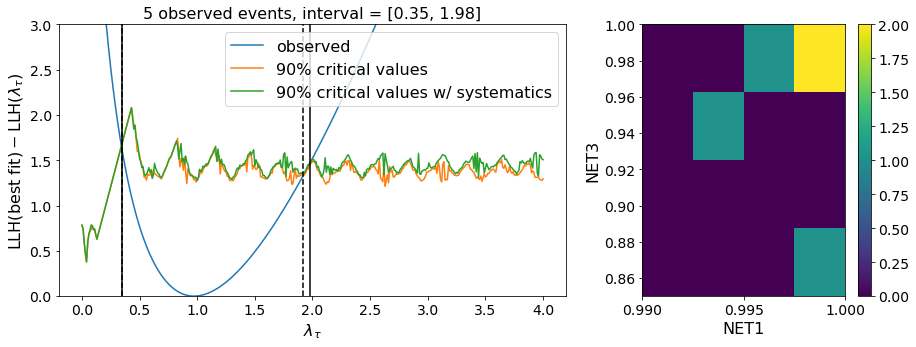

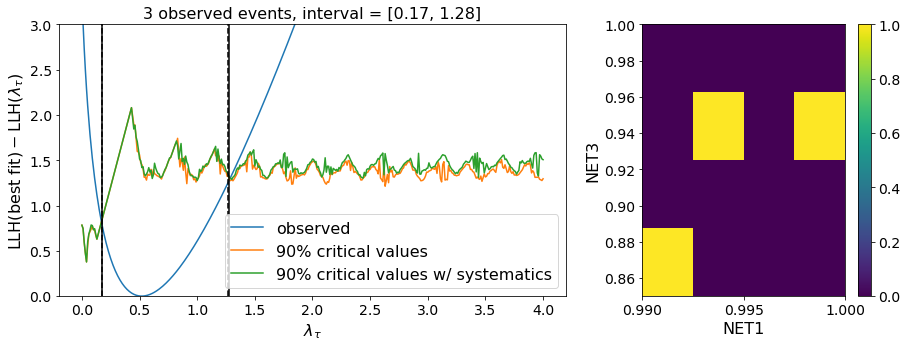

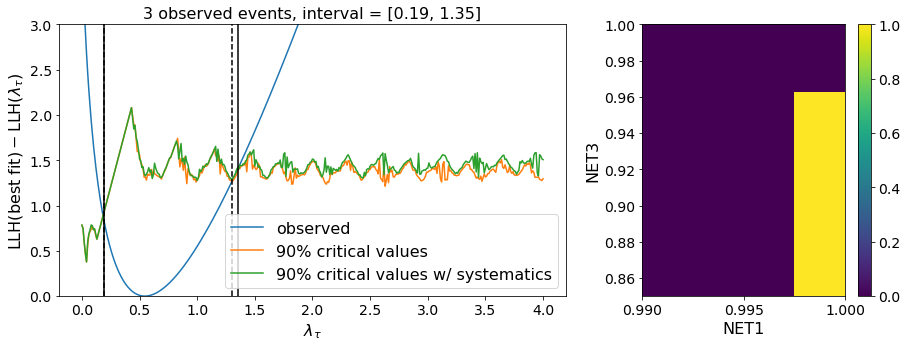

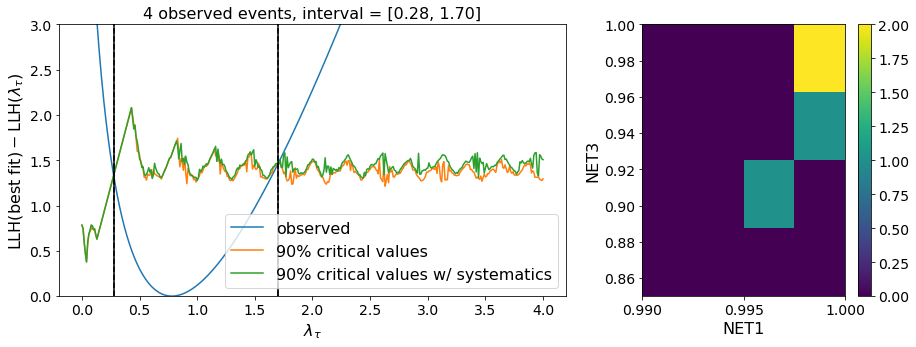

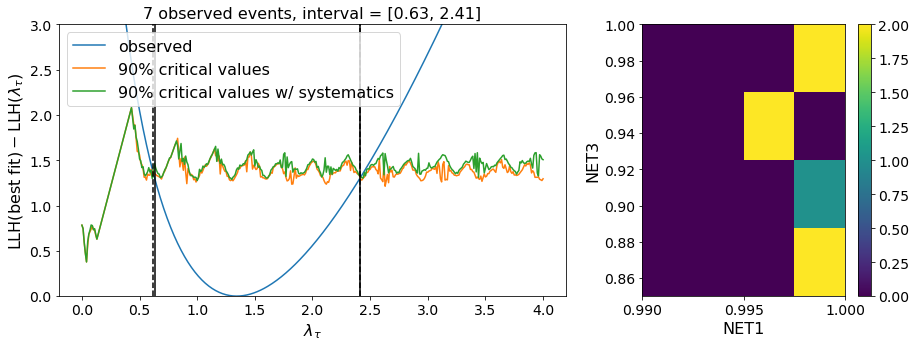

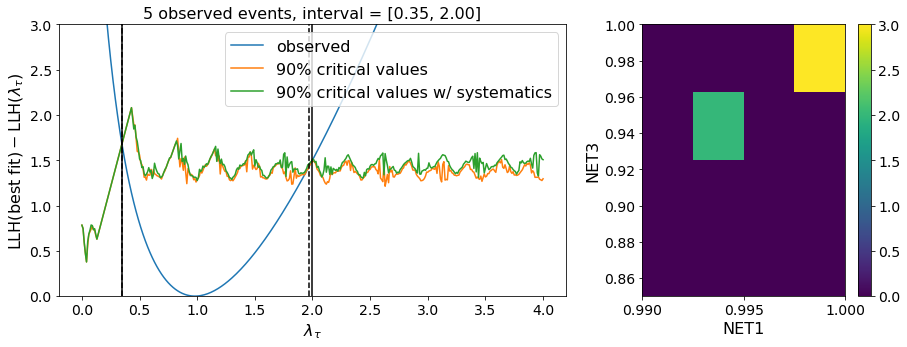

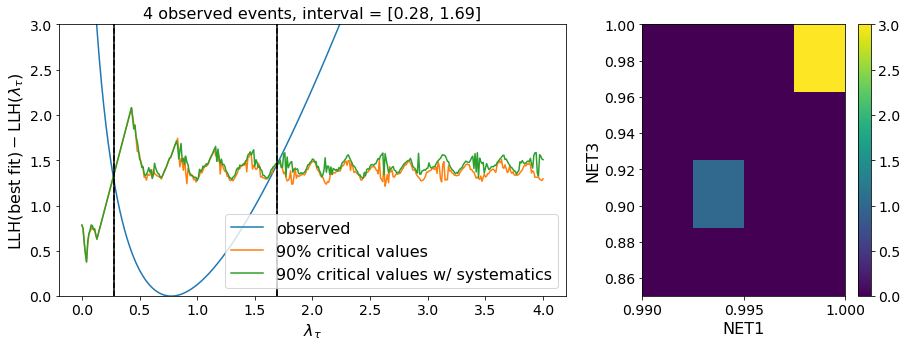

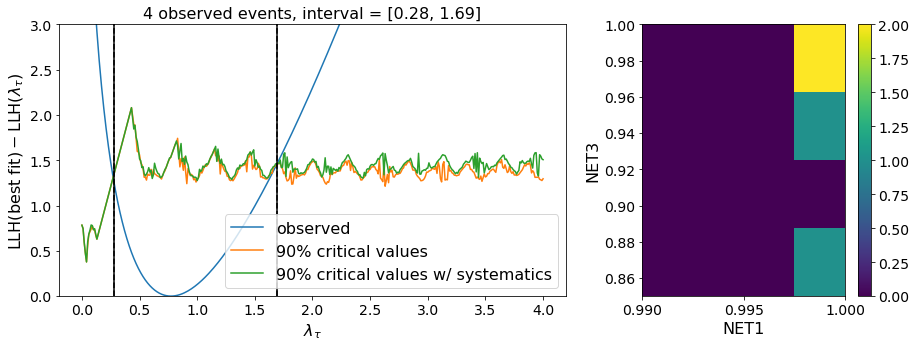

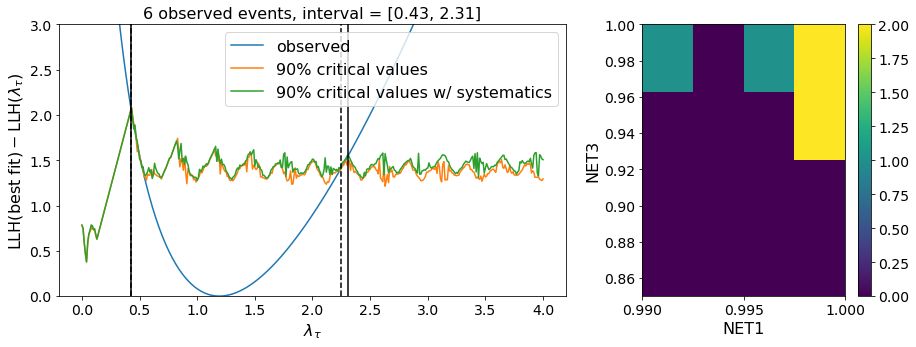

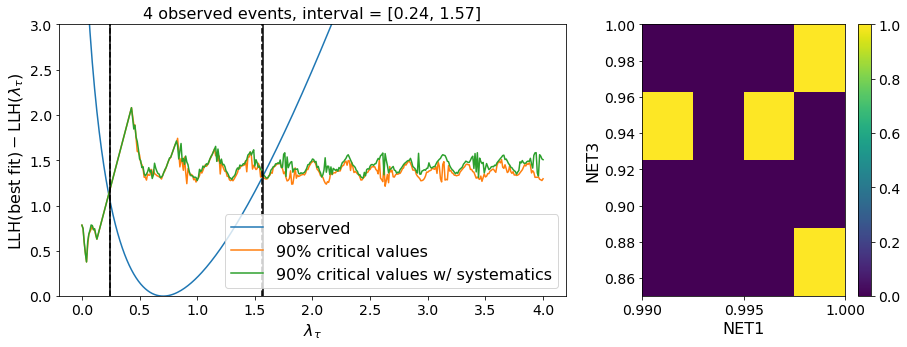

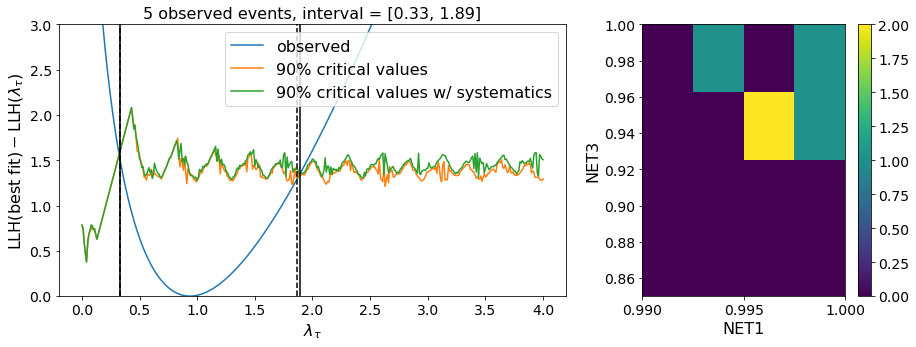

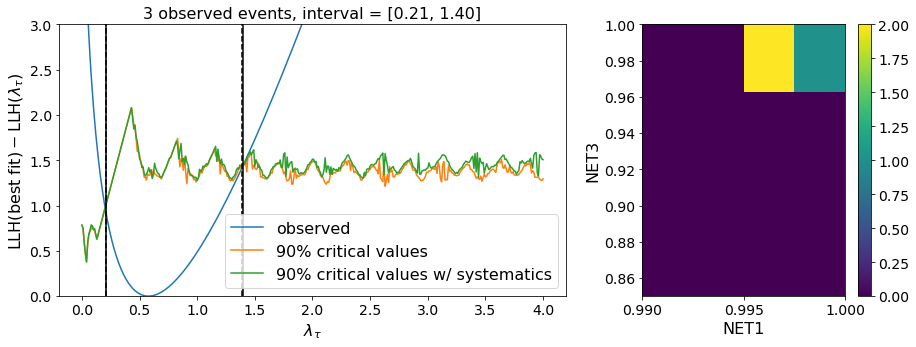

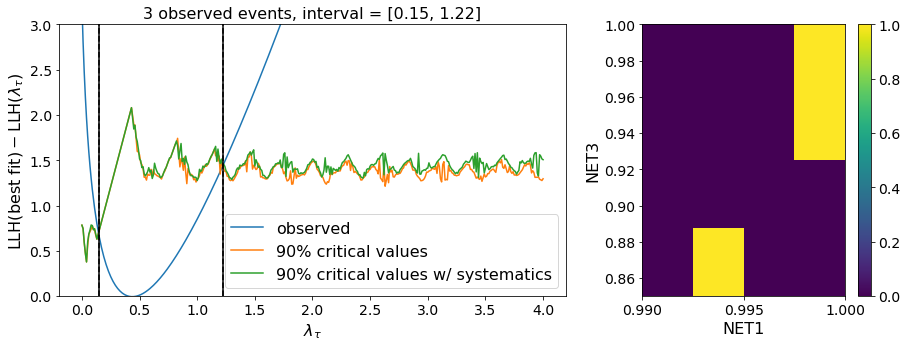

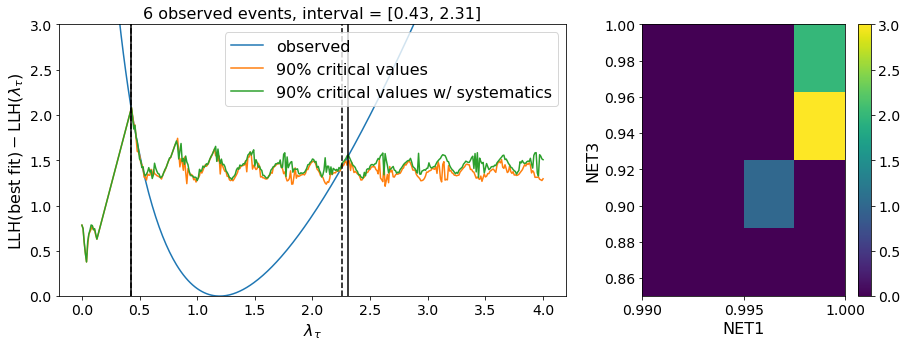

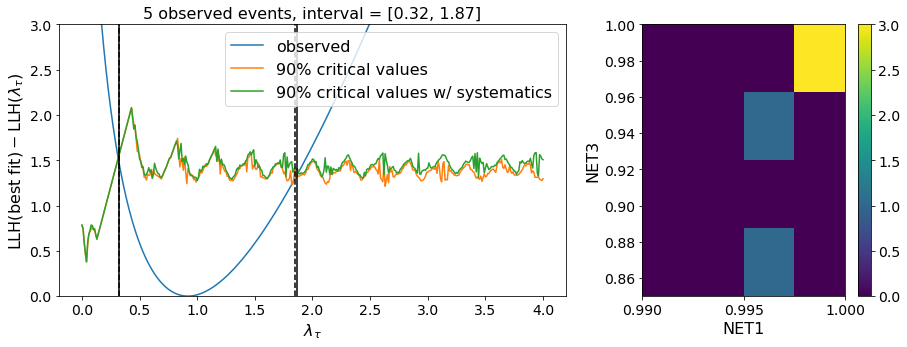

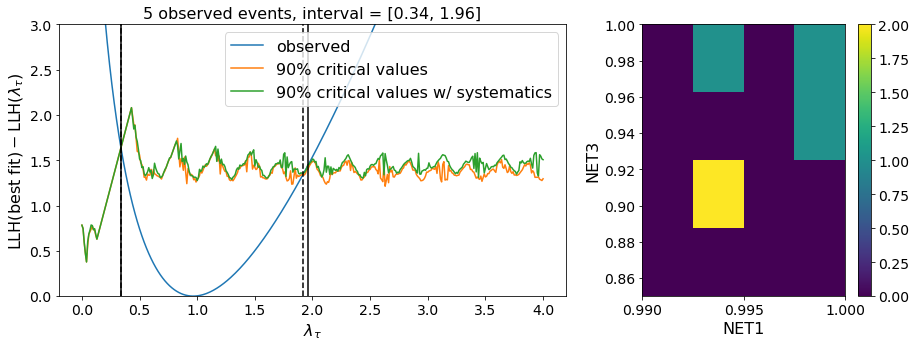

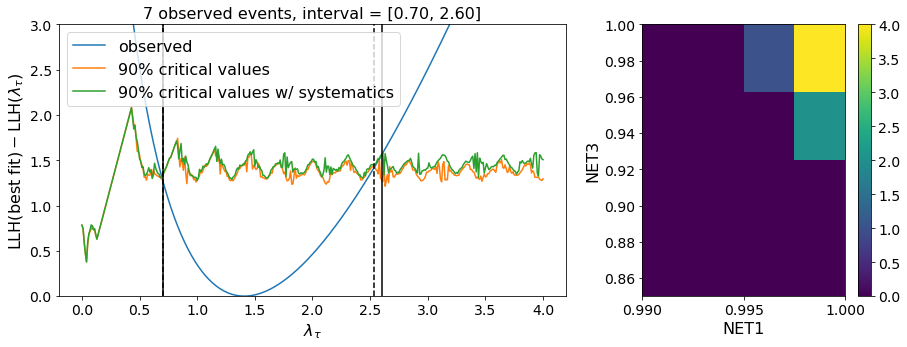

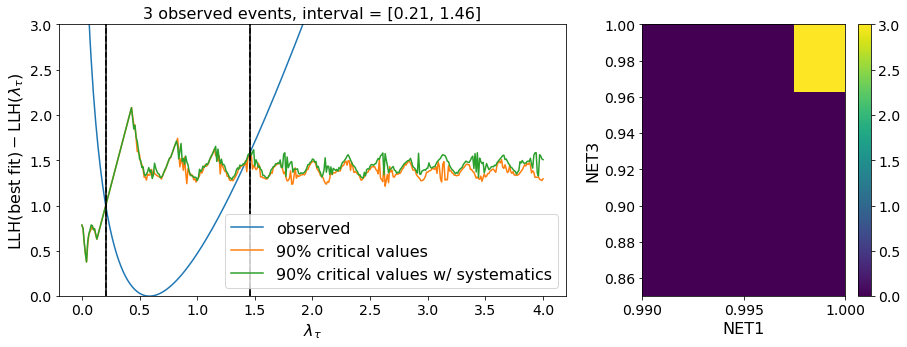

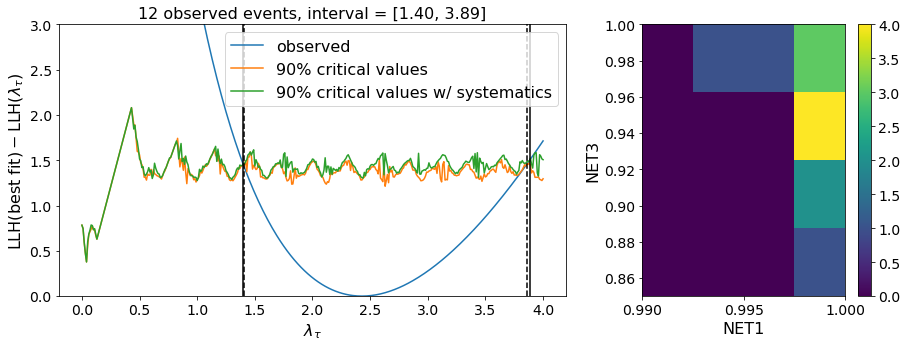

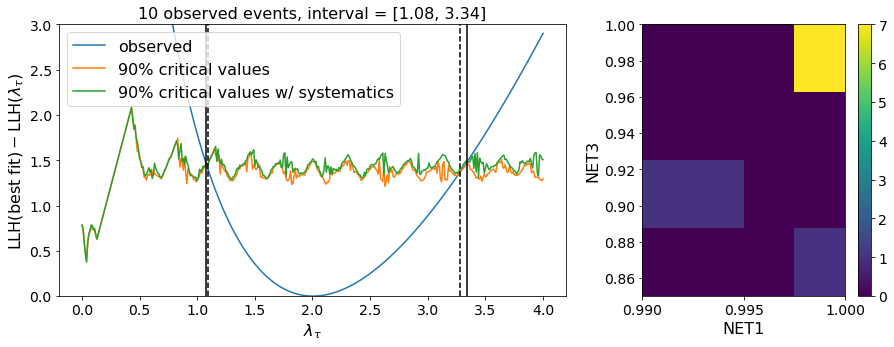

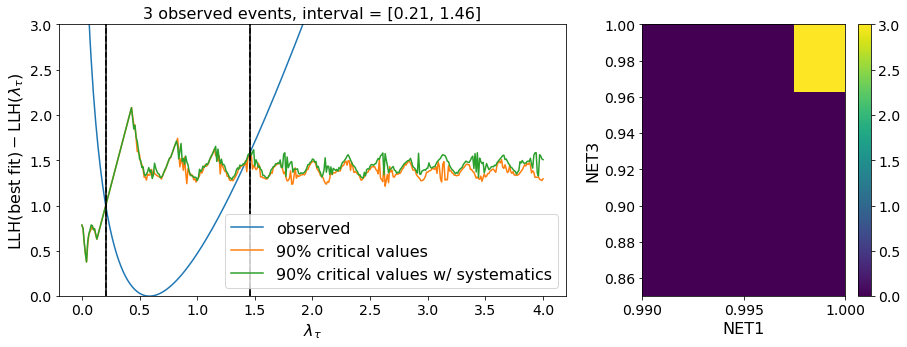

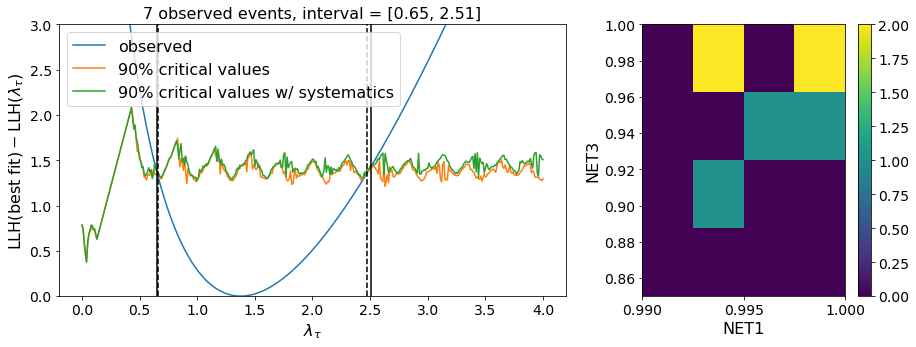

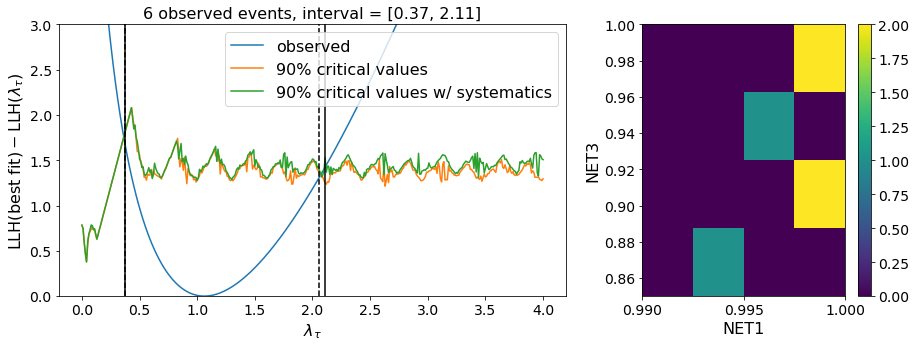

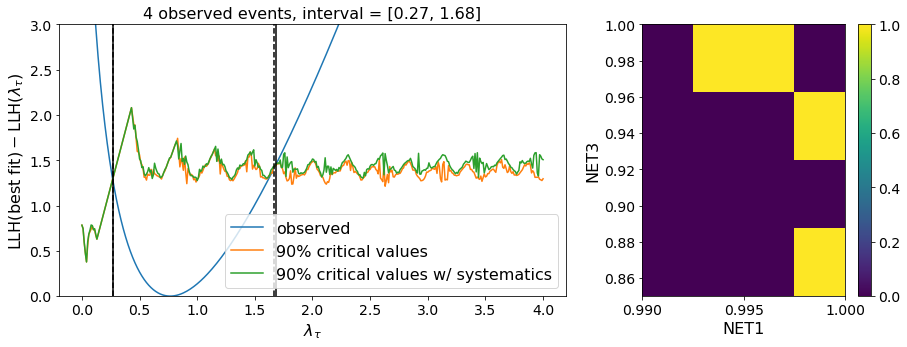

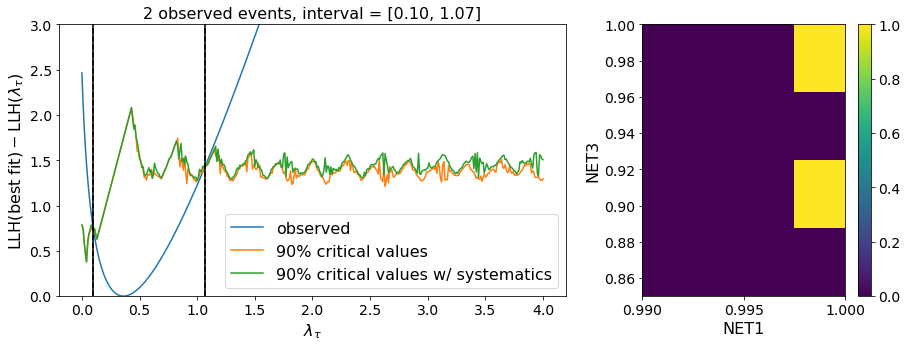

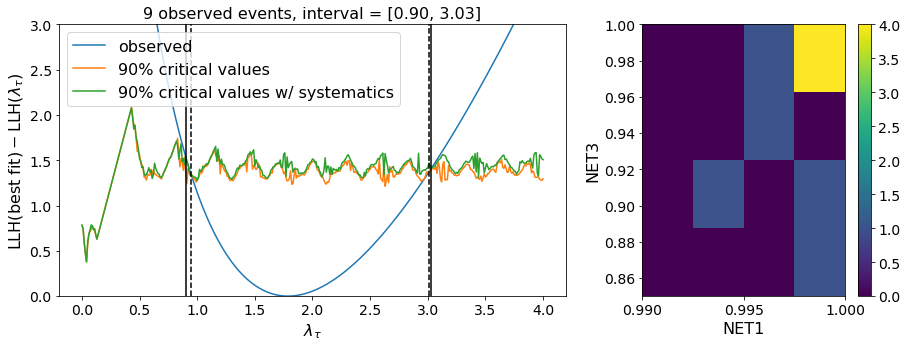

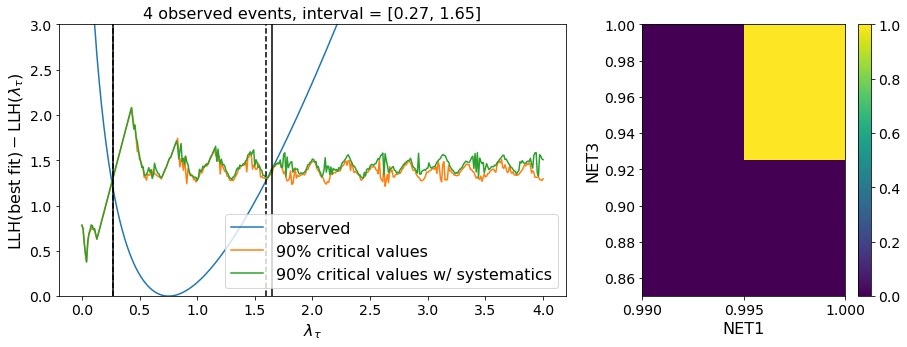

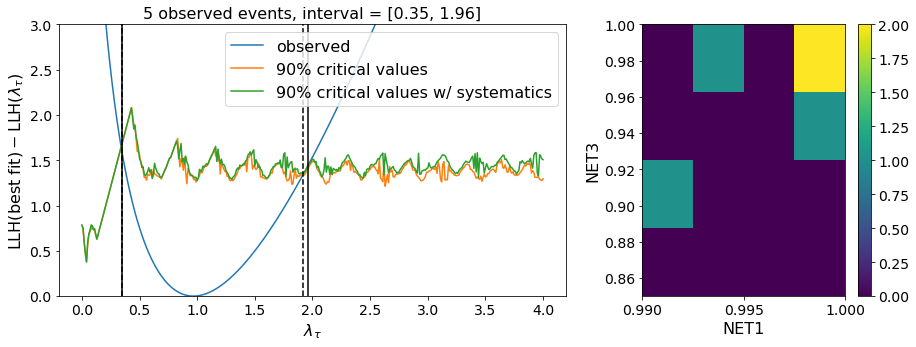

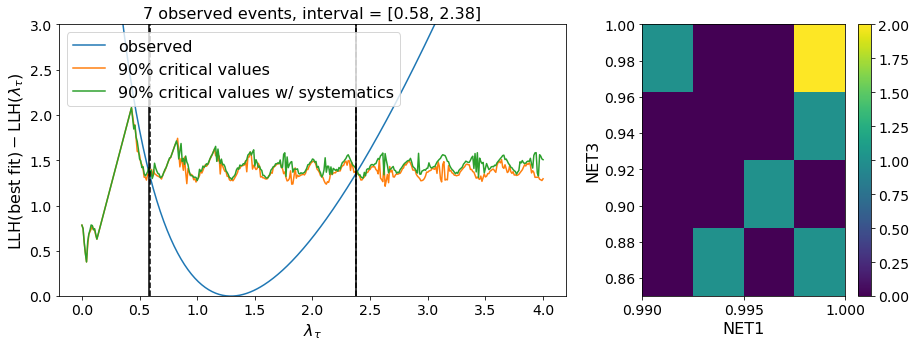

In [35]:
for i in range(30):
    plot_pseudo_expt(scans[i], ts_plane['lambdas'], lower_lims[i], upper_lims[i], ts_plane['critical_values'].T, 
                     lower_lims_syst[i], upper_lims_syst[i], ts_plane_syst['critical_values'].T, syst_hists[i])
    plt.show()

In [36]:
sample_scan = ana.scan_TS(sample_hist, ts_plane['lambdas'])[0]
accepted = np.argwhere(sample_scan <= ts_plane['critical_values'][:, 1])
sample_lower_lim = ts_plane['lambdas'][accepted[0][0]]
sample_upper_lim = ts_plane['lambdas'][accepted[-1][0]]
accepted_syst = np.argwhere(sample_scan <= ts_plane_syst['critical_values'][:, 1])
sample_lower_syst = ts_plane['lambdas'][accepted_syst[0][0]]
sample_upper_syst = ts_plane['lambdas'][accepted_syst[-1][0]]

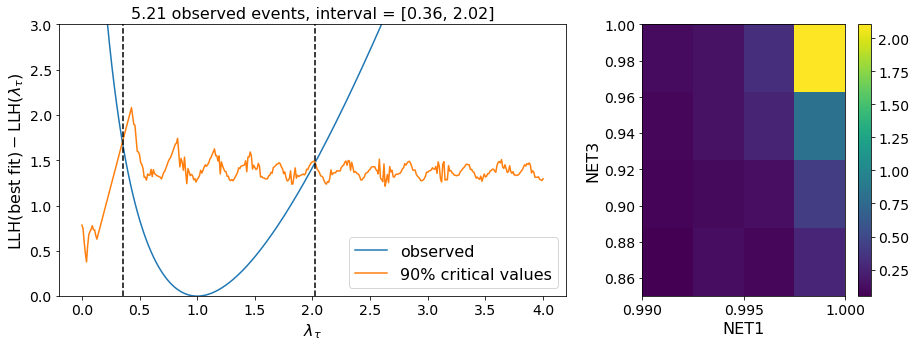

In [37]:
plot_pseudo_expt(sample_scan, ts_plane['lambdas'], sample_lower_lim, sample_upper_lim, ts_plane['critical_values'].T, 
                 sample_lower_syst, sample_upper_syst, ts_plane_syst['critical_values'].T, sample_hist, show_syst=False)

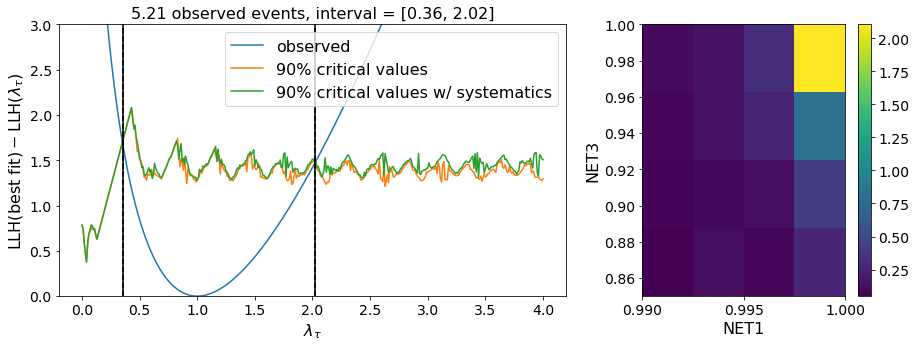

In [55]:
plot_pseudo_expt(sample_scan, ts_plane['lambdas'], sample_lower_lim, sample_upper_lim, ts_plane['critical_values'].T, 
                 sample_lower_syst, sample_upper_syst, ts_plane_syst['critical_values'].T, sample_hist)
plt.gcf().savefig('HESE_asimov_hist.png', bbox_inches='tight')

Text(0, 0.5, '$\\mathrm{LLH}(\\mathrm{best~fit}) - \\mathrm{LLH}(\\lambda_\\tau)$')

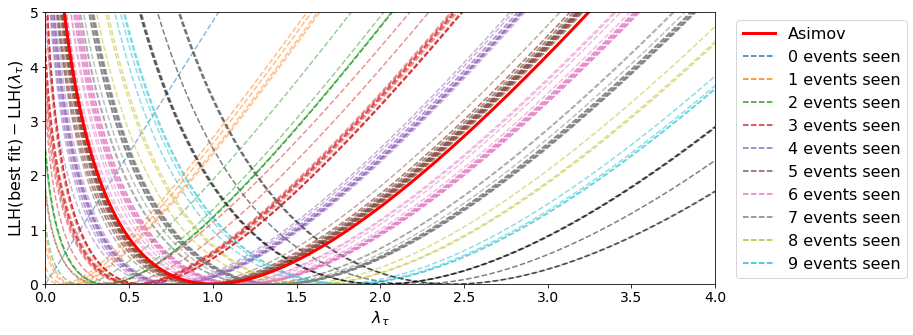

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))

for s, hist in zip(scans[:100], syst_hists):
    color_ind = int(hist.sum())
    color = f'C{color_ind}' if color_ind < 10 else 'k'
    ax.plot(ts_plane['lambdas'], s, '--', alpha=0.5, color=color)
ax.plot(ts_plane['lambdas'], sample_scan, 'r', linewidth=3, label='Asimov')

for i in range(10):
    ax.plot([0], [0], '--', color=f'C{i}', label= f'{i} events seen')

ax.legend(bbox_to_anchor=(1.02, 1))
    
ax.set_ylim(0, 5)
ax.set_xlim(0, 4)
ax.set_xlabel(r'$\lambda_\tau$')
ax.set_ylabel(r'$\mathrm{LLH}(\mathrm{best~fit}) - \mathrm{LLH}(\lambda_\tau)$')

Sample the null hypo TS many times

In [40]:
import multiprocessing

In [41]:
def sample_null(n_trials, batch_size=100_000, with_syst=True):
    ana = Analysis(exp_df, livetime, net1_bins, net3_bins,
               astro_phi=ASTRO_PHI, astro_gamma=ASTRO_GAMMA,
               conv_model='honda2006',
               prompt_model='H3a_SIBYLL23C_pr',
               syst_slopes=syst_slopes,
               syst_widths=syst_widths,
               prior_types=prior_types,
               astro_norm_mean=astro_norm_mean,
               astro_norm_width=astro_norm_width,
               conv_norm_mean=conv_norm_mean,
               conv_norm_width=conv_norm_width,
               prompt_norm_mean=prompt_norm_mean,
               prompt_norm_width=prompt_norm_width,
               mg_norm_mean=mg_norm_mean,
               mg_norm_width=mg_norm_width)
    
    out = []
    n_sampled = 0
    while n_sampled < n_trials:
        null_ts_with_syst, _ = ana.sample_TS(0, batch_size, with_syst=with_syst)
        out.append(null_ts_with_syst)
        
        n_sampled += batch_size
    
    return np.hstack(out)

In [42]:
%%time
n_trials = 5_000_000
with multiprocessing.Pool() as p:
    null_ts_samples = p.map(sample_null, 4*[n_trials])
# include the samples from earlier
null_ts_samples.append(null_ts_with_syst)
null_ts_samples = np.hstack(null_ts_samples)

CPU times: user 35.5 s, sys: 1min 11s, total: 1min 46s
Wall time: 3min 9s


In [43]:
len(null_ts_samples)

23000000

### do same without systematics

In [44]:
%%time
n_trials = 7_000_000
with multiprocessing.Pool() as p:
    null_ts_samples_no_syst = p.starmap(sample_null, zip(4*[n_trials], 4*[100000], 4*[False]))
# include the samples from earlier
null_ts_samples_no_syst.append(null_ts)
null_ts_samples_no_syst = np.hstack(null_ts_samples_no_syst)

CPU times: user 1min 32s, sys: 3min 1s, total: 4min 33s
Wall time: 5min 17s


In [45]:
len(null_ts_samples_no_syst)

31000000

In [46]:
from scipy import stats
norm = stats.norm()
five_sig_p_value = 2*norm.cdf(-5)

In [47]:
five_sig_percentile = 100*(1-five_sig_p_value)

11.046480352879616
14
0.4623661295165649
above 5 0.36587929136222597
above asimov 2.565217391304348e-06
n sig: 4.702876385887041
11.887087355532012
11.046480352879616
example TS: 10.34197199981288


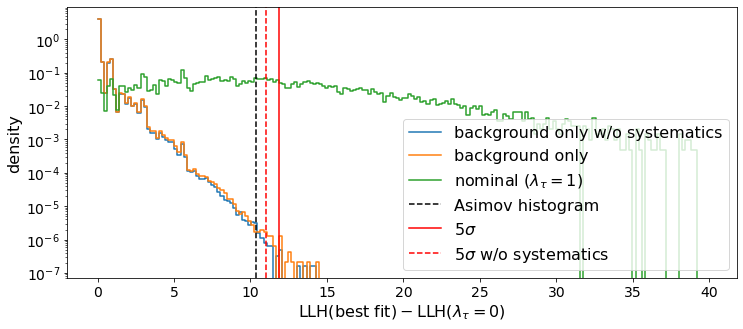

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))

syst_hist, _ = np.histogram(null_ts_samples, bins=ts_bins, density=True)
no_syst_hist, _ = np.histogram(null_ts_samples_no_syst, bins=ts_bins, density=True)


ax.step(ts_bins[:-1], no_syst_hist, where='post', label='background only w/o systematics')
ax.step(ts_bins[:-1], syst_hist, where='post', label='background only')
ax.step(ts_bins[:-1], nom_hist, where='post', label=r'nominal ($\lambda_\tau = 1$)')
ax.axvline(sample_scan[0], color='black', linestyle='--', label='Asimov histogram')

five_sig_cv = np.percentile(null_ts_samples, five_sig_percentile, interpolation='higher')
five_sig_cv_no_syst = np.percentile(null_ts_samples_no_syst, five_sig_percentile, interpolation='higher')
print(five_sig_cv_no_syst)

ax.axvline(five_sig_cv,
           color='red', label=r'5$\sigma$')
ax.axvline(five_sig_cv_no_syst, linestyle='--',
           color='red', label=r'5$\sigma$ w/o systematics')
ax.set_xlabel(r'$\lambda_\tau = 0$ TS')
ax.set_ylabel('density')
ax.set_yscale('log')

above_example = np.argwhere(ts_bins >= sample_scan[0])[0][0]

n_above_5 = np.count_nonzero(null_ts_samples >= five_sig_cv)
print(n_above_5)

print(np.trapz(nom_hist[above_example:], ts_bins[above_example:-1]))

above_5 =  np.argwhere(ts_bins >= five_sig_cv)[0][0]
print('above 5', np.trapz(nom_hist[above_5:], ts_bins[above_5:-1]))
above_asimov = len(null_ts_samples[null_ts_samples > sample_scan[0]]) / len(null_ts_samples)
print('above asimov', above_asimov)
n_sig = -norm.ppf(above_asimov / 2)
print(f'n sig: {n_sig}')

ax.legend(fontsize=16)

print(five_sig_cv)
print(five_sig_cv_no_syst)
ax.set_xlabel(r"$\mathrm{LLH}(\mathrm{best~fit}) - \mathrm{LLH}(\lambda_\tau=0)$")

print(f"example TS: {sample_scan[0]}")
plt.gcf().savefig('HESE_null_rejection_p_value.png', bbox_inches='tight')